# LIF-net forward-model predictions
Demo notebook showcasing finite-impulse response (FIR) filter functions predicted using 
``LFPykernels`` for biophysics-based forward model predictions from a point-neuron network model 
implemented in NEST (https://nest-simulator.org).

The point-neuron network is set up to mimic the spiking activity of a multicompartment (MC) neuron network model in terms of population spike rates and power spectra. 
The calculations of spike-to-signal filter kernels for local field potentials (LFP) across depth and 
current dipole moment is based on the description of the MC neuron network model in `example_network_parameters.py`. 

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
import scipy.signal as ss
import example_network_parameters as params
import example_network_methods as methods
from lfpykernels import KernelApprox, GaussCylinderPotential, KernelApproxCurrentDipoleMoment
from plotting import draw_lineplot, remove_axis_junk, annotate_subplot

from copy import deepcopy
import neuron
import nest
from pynestml.frontend.pynestml_frontend import to_nest, install_nest

In [3]:
plt.rcParams.update({
    'axes.xmargin': 0.01,
    'axes.ymargin': 0.01,
})

In [4]:
# recompile mod files if needed
mech_loaded = neuron.load_mechanisms('mod')
if not mech_loaded:
    os.system('cd mod && nrnivmodl && cd -')
    mech_loaded = neuron.load_mechanisms('mod')
print(f'mechanisms loaded: {mech_loaded}')

mechanisms loaded: True


In [5]:
# parameters
pset = dict(
    weight_EE=0.00015,  # E to E connection weight
    weight_IE=0.00012,  # E to I
    weight_EI=0.0045,   # I to E
    weight_II=0.0020,   # I to I
    weight_scaling=1.,  # global weight scaling
    biophys='frozen',   # passive-frozen biophysics
    n_ext=[450, 160],   # number of external inputs per cell
    g_eff=True          # if True, account for the effective membrane time constants
)

In [6]:
TRANSIENT = 200  # ignore 1st 200 ms of simulation in analyses
dt = params.networkParameters['dt']
tstop = params.networkParameters['tstop']
tau = 50  # time lag relative to spike for kernel predictions

# Assumed average firing rate of presynaptic populations X
mean_nu_X = dict(E=2.3, I=4.9)  # spikes/s

# assumed typical postsynaptic potential for each population
Vrest = -65. 

# presynaptic activation time
t_X = TRANSIENT

In [7]:
# Compile and install NESTML FIR_filter.nestml model
nestml_model_file = 'FIR_filter.nestml'
nestml_model_name = 'fir_filter_nestml'
target_path = '/tmp/fir-filter'
logging_level = 'INFO'
module_name = 'nestmlmodule'
store_log = False
suffix = '_nestml'
dev = True

input_path = os.path.join(os.path.realpath(nestml_model_file))
nest_path = nest.ll_api.sli_func("statusdict/prefix ::")
to_nest(input_path, target_path, logging_level, module_name, store_log, suffix, dev)
install_nest(target_path, nest_path)

nest.set_verbosity("M_ALL")
nest.Install(module_name)

nest.ResetKernel()

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /opt/data/examples/FIR_filter.nestml
[3,GLOBAL, INFO]: Start processing '/opt/data/examples/FIR_filter.nestml'!
[4,fir_filter_nestml, WARNING, [32:0;70:0]]: Output block not defined!
[5,fir_filter_nestml, INFO, [32:0;70:0]]: Start building symbol table!
[6,fir_filter_nestml, WARNING, [44:3;44:15]]: Variable 'N' has the same name as a physical unit!
[7,fir_filter_nestml, WARNING, [45:3;45:15]]: Variable 'h' has the same name as a physical unit!
[8,fir_filter_nestml, WARNING, [58:3;58:15]]: Variable 'k' has the same name as a physical unit!
[9,fir_filter_nestml, INFO, [54:10;54:10]]: Implicit casting from (compatible) type 'real buffer' to 'real'.
[10,fir_filter_nestml, INFO, [59:7;59:7]]: Implicit casting from (compatible) type 'integer' to 'real'.


[11,GLOBAL, INFO]: Given template root path is not an absolute path. Creating the absolute path with default templates directory '/usr/local/lib/python3.8/dist-packag

In [8]:
# create kernels from multicompartment neuron network description
                
# kernel container
H_YX = dict()

# define biophysical membrane properties
if pset['biophys'] == 'frozen':
    set_biophys = [methods.set_frozen_hay2011, methods.make_cell_uniform]
elif pset['biophys'] == 'lin':
    set_biophys = [methods.set_Ih_linearized_hay2011, methods.make_cell_uniform]
else:
    raise NotImplementedError

# synapse max. conductance (function, mean, st.dev., min.):
weights = [[pset['weight_EE'], pset['weight_IE']],
           [pset['weight_EI'], pset['weight_II']]]

# Not using RecExtElectrode class as we anyway average potential in
# space for each source element. This is to replaced by
# a closed form volumetric method (point source & volumetric contacts
# should result in same mappings as volumetric source & point contacs)

# Predictor assuming planar disk source elements convolved with Gaussian
# along z-axis
gauss_cyl_potential = GaussCylinderPotential(
    cell=None,
    z=params.electrodeParameters['z'],
    sigma=params.electrodeParameters['sigma'],
    R=params.populationParameters['pop_args']['radius'],
    sigma_z=params.populationParameters['pop_args']['scale'],
    )

# set up recording of current dipole moments. 
# The class KernelApproxCurrentDipoleMoment accounts only for contributions
# along the vertical z-axis as other components cancel with rotational symmetry
current_dipole_moment = KernelApproxCurrentDipoleMoment(cell=None)


# compute kernels for each pair of pre- and postsynaptic populations.
# Iterate over presynaptic populations
for i, (X, N_X) in enumerate(zip(params.population_names,
                                 params.population_sizes)):
    # iterate over postsynaptic populations
    for j, (Y, N_Y, morphology) in enumerate(zip(params.population_names,
                                                 params.population_sizes,
                                                 params.morphologies)):
        # set up LFPy.NetworkCell parameters for postsynaptic units
        cellParameters = deepcopy(params.cellParameters)
        cellParameters.update(dict(
            morphology=morphology,
            custom_fun=set_biophys,
            custom_fun_args=[dict(Vrest=Vrest), dict(Vrest=Vrest)],
        ))

        # some inputs must be lists
        synapseParameters = [
            dict(weight=weights[ii][j],
                 syntype='Exp2Syn',
                 **params.synapseParameters[ii][j])
            for ii in range(len(params.population_names))]
        synapsePositionArguments = [
            params.synapsePositionArguments[ii][j]
            for ii in range(len(params.population_names))]

        # Create KernelApprox object
        kernel = KernelApprox(
            X=params.population_names,
            Y=Y,
            N_X=np.array(params.population_sizes),
            N_Y=N_Y,
            C_YX=np.array(params.connectionProbability[i]),
            cellParameters=cellParameters,
            populationParameters=params.populationParameters['pop_args'],
            multapseFunction=params.multapseFunction,
            multapseParameters=[params.multapseArguments[ii][j] for ii in range(len(params.population_names))],
            delayFunction=params.delayFunction,
            delayParameters=[params.delayArguments[ii][j] for ii in range(len(params.population_names))],
            synapseParameters=synapseParameters,
            synapsePositionArguments=synapsePositionArguments,
            extSynapseParameters=params.extSynapseParameters,
            nu_ext=1000. / params.netstim_interval,
            n_ext=pset['n_ext'][j],
            nu_X=mean_nu_X,
        )

        # make kernel predictions and update container dictionary
        H_YX['{}:{}'.format(Y, X)] = kernel.get_kernel(
            probes=[gauss_cyl_potential, current_dipole_moment],
            Vrest=Vrest, dt=dt, X=X, t_X=t_X, tau=tau,
            g_eff=pset['g_eff'],
            fir=True
        )

In [9]:
# create NEST LIF network
class Network(object):
    """Class implementing a LIF network"""
    def __init__(self, 
                 X = ['E', 'I'],
                 N_X=[8192, 1024], 
                 C_m_X=[269., 100.],
                 tau_m_X=[10., 10.],
                 E_L_X=[-65., -65.],
                 C_YX=[[0.5, 0.5], [0.5, 0.5]],
                 J_YX=[[1.5, 1.5], [-20., -15.]],
                 delay_YX = [[3., 3.], [3.0, 3.0]],
                 tau_syn_YX = [[0.5, 0.5], [0.5, 0.5]],
                 n_ext=[450, 160],
                 nu_ext=40.,
                 J_ext=27.6,
                 model='iaf_psc_exp',
                 dt=2**-4,
                 verbose=False,
                 **kwargs
                ):
        self.X = X
        self.N_X = N_X
        self.C_m_X = C_m_X
        self.tau_m_X = tau_m_X
        self.E_L_X = E_L_X
        self.C_YX = C_YX
        self.J_YX = J_YX
        self.delay_YX = delay_YX
        self.tau_syn_YX = tau_syn_YX
        self.n_ext = n_ext
        self.nu_ext = nu_ext
        self.J_ext = J_ext
        self.model = model
        self.dt = dt
        self.verbose = verbose
        
        self._create()
        self._connect()
        
    def _create(self):
        """Create network nodes and connections"""

        nest.ResetKernel()
        nest.SetKernelStatus(dict(local_num_threads=1, resolution=self.dt, tics_per_ms=1000 / dt))
        
        if self.verbose:
            print('creating...')
        # neurons
        self.neurons = {}
        for (X, N, C_m, tau_m, E_L, (tau_syn_ex, tau_syn_in)
             ) in zip(
                self.X, self.N_X, self.C_m_X, self.tau_m_X, self.E_L_X, self.tau_syn_YX):
            neuron_params = dict(
                C_m = C_m,
                tau_m = tau_m,
                E_L = E_L,
                V_reset = E_L,
                tau_syn_ex=tau_syn_ex,
                tau_syn_in=tau_syn_in
            )
            self.neurons[X] = nest.Create(self.model, N, neuron_params)

        # poisson generators
        self.poisson = {}
        for X, n_ext in zip(self.X, self.n_ext):
            self.poisson[X] = nest.Create('poisson_generator', 1, dict(rate=self.nu_ext * n_ext))
        
        # spike recorders
        self.spike_recorders = {}
        for X in self.X:
            self.spike_recorders[X] = nest.Create('spike_recorder', 1)
        
    def _connect(self):
        if self.verbose:
            print('connecting...')
        for i, X in enumerate(self.X):
            # recurrent connections
            for j, Y in enumerate(self.X):
                if self.verbose:
                    print(f'connecting {X} to {Y}...')
                conn_spec = dict(
                    rule = 'pairwise_bernoulli',
                    p = self.C_YX[i][j],
                )
                syn_spec = dict(
                    synapse_model = 'static_synapse',
                    weight = nest.math.redraw(
                        nest.random.normal(
                            mean=self.J_YX[i][j],
                            std=abs(self.J_YX[i][j]) * 0.1,
                        ),
                        min=0. if self.J_YX[i][j] >= 0 else np.NINF,
                        max=np.Inf if self.J_YX[i][j] >= 0 else 0.,
                    ),

                    delay = nest.math.redraw(
                        nest.random.normal(
                            mean=self.delay_YX[i][j],
                            std=self.delay_YX[i][j] * 0.5,
                        ),
                        min=0.3,
                        max=np.Inf,
                    )
                )
                
                nest.Connect(self.neurons[X], self.neurons[Y], conn_spec, syn_spec)
            
            # poisson generators
            if self.verbose:
                print(f'connecting poisson_generator[{X}] to {X}...')
            nest.Connect(self.poisson[X], self.neurons[X], 'all_to_all', dict(weight=self.J_ext))
            
            # recorders
            if self.verbose:
                print(f'connecting spike_recorder[{X}] to {X}...')
            nest.Connect(self.neurons[X], self.spike_recorders[X])

            
    def create_fir_filters(self, H_YX):
        """Create sets of FIR filters for each signal probe
        
        Parameters
        ----------
        kernels: nested dict
        """
        keys = list(H_YX[f'{self.X[0]}:{self.X[0]}'].keys())
        n_kernels = len(keys)
        n_filters_per_kernel = [] 
        for key in keys:
            n_filters_per_kernel += [H_YX[f'{self.X[0]}:{self.X[0]}'][key].shape[0]]
            
        # create container
        if not hasattr(self, 'fir_filters'):
            self.fir_filters = dict()
            
        # create sets of FIR_filter nodes for each type of measurement and 
        # presynaptic population (ignoring Poisson generators)
        for k in keys:
            self.fir_filters[k] = dict()
            # presynaptic
            for i, X in enumerate(self.X):
                # self.fir_filters[k][X] = []
                # postsynaptic
                for j, Y in enumerate(self.X):
                    H = H_YX[f'{Y}:{X}'][k]
                    
                    # create one fir_filter node for each row
                    fir_filter_params = []
                    for h in H:
                        fir_filter_params += [dict(
                            N=h.size,  # filter order
                            h=h,  # filter coefficients
                        )]
                    self.fir_filters[k][f'{Y}:{X}'] = nest.Create('fir_filter_nestml', 
                                                                  H.shape[0], 
                                                                  fir_filter_params)
                    
        # create recording multimeters, one per probe, sample every dt
        self.multimeters = dict()
        for k in keys:
            self.multimeters[k] = dict()
            for X in self.X:
                for Y in self.X:
                    self.multimeters[k][f'{Y}:{X}'] = nest.Create('multimeter', 1, 
                                                                  {'interval': self.dt, 'label': f'{k}_{Y}:{X}'})
                    self.multimeters[k][f'{Y}:{X}'].set({"record_from": ["y"]})
        
        # connect FIR filter nodes to the corresponding presynaptic populations at minimum delay
        for k in keys:
            for i, X in enumerate(self.X):
                for Y in self.X:
                    nest.Connect(self.neurons[f'{X}'], 
                                 self.fir_filters[k][f'{Y}:{X}'], 
                                 syn_spec=dict(delay=self.dt))
        
        # connect multimeters
        for k in keys:
            for i, X in enumerate(self.X):
                for Y in self.X:
                    nest.Connect(self.multimeters[k][f'{Y}:{X}'], 
                                 self.fir_filters[k][f'{Y}:{X}'])
        
        
    def simulate(self, tstop=6000):
        """Instantiate and run simulation"""
        if self.verbose:
            print('simulating...')
        nest.Simulate(tstop)
        if self.verbose:
            print('done!')

In [10]:
# best fit params from fit_LIF_net
res_x = np.array([1.39819177, 1.87482734, -19.12938525, -12.40596036, 28.16271785,
                  3.93631828, 3.55375378, 2.7270546, 3.07831483])
# set up parameter dictionary
lifnet_params = dict(
    X = ['E', 'I'],
    N_X=[8192, 1024], 
    C_m_X=[269., 100.],
    tau_m_X=[10., 10.],
    E_L_X=[-65., -65.],
    C_YX=[[0.5, 0.5], [0.5, 0.5]],
    J_YX=[[res_x[0], res_x[1]], [res_x[2], res_x[3]]],
    delay_YX = [[res_x[5], res_x[6]], [res_x[7], res_x[8]]],
    tau_syn_YX = [[0.5, 0.5], [0.5, 0.5]],
    n_ext=[450, 160],
    nu_ext=40.,
    J_ext=res_x[4],
    model='iaf_psc_exp',
    dt=2**-4,
)

In [11]:
# create network and FIR filter nodes
net = Network(**lifnet_params)
net.create_fir_filters(H_YX=H_YX)

In [12]:
# run simulation
net.simulate(tstop=tstop)

In [13]:
# multimeters reading out spike rates filtered using the different sets of kernels
net.multimeters

{'GaussCylinderPotential': {'E:E': NodeCollection(metadata=None, model=multimeter, size=1, first=9285),
  'I:E': NodeCollection(metadata=None, model=multimeter, size=1, first=9286),
  'E:I': NodeCollection(metadata=None, model=multimeter, size=1, first=9287),
  'I:I': NodeCollection(metadata=None, model=multimeter, size=1, first=9288)},
 'KernelApproxCurrentDipoleMoment': {'E:E': NodeCollection(metadata=None, model=multimeter, size=1, first=9289),
  'I:E': NodeCollection(metadata=None, model=multimeter, size=1, first=9290),
  'E:I': NodeCollection(metadata=None, model=multimeter, size=1, first=9291),
  'I:I': NodeCollection(metadata=None, model=multimeter, size=1, first=9292)}}

In [14]:
# something in NEST resets matplotlib settings
%matplotlib inline

In [15]:
def get_spike_rate(times):
    bins = (np.arange(TRANSIENT / dt, tstop / dt + 1)
            * dt - dt / 2)
    hist, _ = np.histogram(times, bins=bins)
    return bins, hist.astype(float)

In [16]:
def get_mean_spike_rate(times):
    times = times[times >= TRANSIENT]
    return times.size /  (tstop - TRANSIENT) * 1000

In [17]:
# mean firing rates of "real" network populations
lif_mean_nu_X = dict()  # mean spike rates
lif_nu_X = dict()  # binned firing rate
for i, X in enumerate(params.population_names):
    times = nest.GetStatus(net.spike_recorders[X])[0]['events']['times']
    times = times[times >= TRANSIENT]

    lif_mean_nu_X[X] = get_mean_spike_rate(times)
    _, lif_nu_X[X] = get_spike_rate(times)

## Visualize results

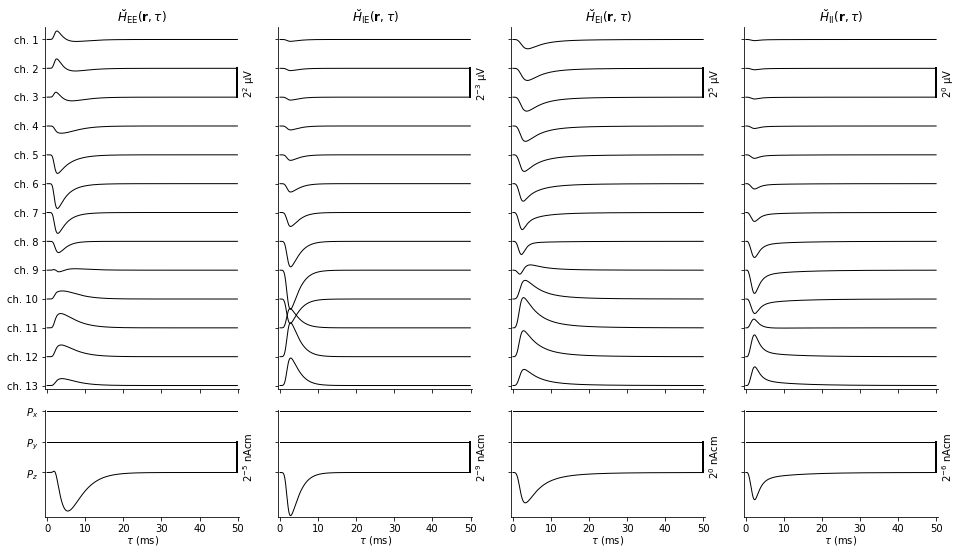

In [18]:
# draw spike-signal kernels (ignoring non-causal contributions which are zero)
fig = plt.figure(figsize=(16, 9))
# create subplots
gs = GridSpec(4, 4)
axes = np.array([[None] * 4] * 2, dtype=object)
for i in range(2):
    for j in range(4):
        if i == 0:
            if j == 0:
                axes[i, j] = fig.add_subplot(gs[:3, j])
            else:
                axes[i, j] = fig.add_subplot(gs[:3, j], sharey=axes[0, 0], sharex=axes[0, 0])
        else:
            if j == 0:
                axes[i, j] = fig.add_subplot(gs[3, j], sharex=axes[0, 0])
            else:
                axes[i, j] = fig.add_subplot(gs[3, j], sharey=axes[1, 0], sharex=axes[0, 0])

vlims = np.zeros((2, 4))
for i, (X, N_X) in enumerate(zip(params.population_names,
                                 params.population_sizes)):
    for j, (Y, N_Y, morphology) in enumerate(zip(params.population_names,
                                                 params.population_sizes,
                                                 params.morphologies)):

        # plot responses, iterate over probes
        for h, (unit, probe) in enumerate(
                zip(['mV', 'nAµm'],
                    ['GaussCylinderPotential', 'KernelApproxCurrentDipoleMoment'])):
            title = (
                r'$\breve{H}_\mathrm{%s %s}(\mathbf{r}, \tau)$'
                % (Y, X)
                )

            if probe == 'KernelApproxCurrentDipoleMoment':
                scaling = 1E-4  # nAum --> nAcm unit conversion
                unit = 'nAcm'
            elif probe == 'GaussCylinderPotential':
                scaling = 1E3  # mV --> uV unit conversion
                unit = r'µV'                
            else:
                scaling = 1

            ax = axes[h, i * 2 + j]
            draw_lineplot(
                ax,
                H_YX['{}:{}'.format(Y, X)][probe] * scaling,
                dt=dt,
                T=(0, tau),
                scaling_factor=1.,
                vlimround=(None
                           if vlims[h, i * 2 + j] == 0
                           else vlims[h, i * 2 + j]),
                label=f"{pset['biophys']}",
                scalebar=True,
                unit=unit,
                ylabels=True,
                color='k',
                ztransform=False
                )
            if probe == 'KernelApproxCurrentDipoleMoment':
                ax.set_yticklabels(['$P_{}$'.format(x) for x in 'xyz'])
            if h == 0:
                ax.set_title(title)
                ax.set_xlabel('')
                plt.setp(ax.get_xticklabels(), visible=False)
            if (i * 2 + j) == 0:
                ax.set_ylabel(probe)
            else:
                # ax.set_ylabel('')
                plt.setp(ax.get_yticklabels(), visible=False)
            ax.set_ylabel('')
            if h == 1:
                ax.set_xlabel(r'$\tau$ (ms)')

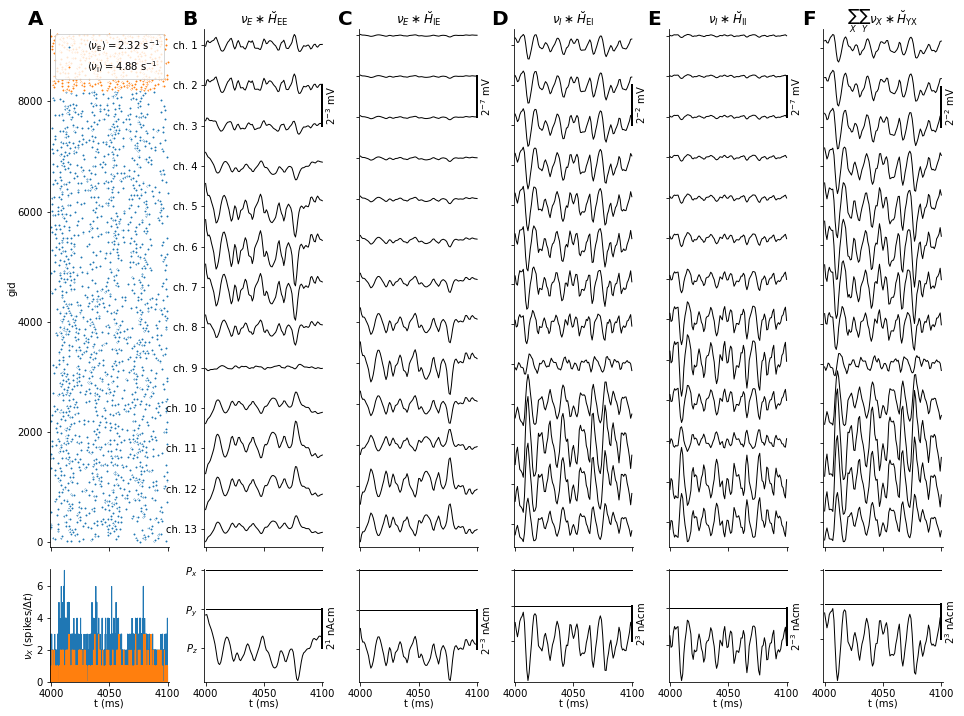

In [19]:
# plot LIF-network spikes, spike rates, signal predictions
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(5, 6, wspace=0.3)

ax = fig.add_subplot(gs[:-1, 0])
remove_axis_junk(ax)
annotate_subplot(ax, ncols=6, nrows=1, letter='A', linear_offset=0.02)

T = [4000, 4100]
for i, Y in enumerate(net.X):
    times = nest.GetStatus(net.spike_recorders[Y])[0]['events']['times']
    gids = nest.GetStatus(net.spike_recorders[Y])[0]['events']['senders']

    gids = gids[times >= TRANSIENT]
    times = times[times >= TRANSIENT]

    ii = (times >= T[0]) & (times <= T[1])
    ax.plot(times[ii], gids[ii], '.',
            mfc='C{}'.format(i),
            mec='w',
            label=r'$\langle \nu_\mathrm{%s} \rangle =%.2f$ s$^{-1}$' % (
                Y, lif_mean_nu_X[Y] / net.N_X[i])
           )
ax.legend(loc=1)
ax.axis('tight')
ax.set_xticklabels([])
ax.set_ylabel('gid', labelpad=0)


#####
# Rates
####
ax = fig.add_subplot(gs[-1, 0])
remove_axis_junk(ax)

Delta_t = dt
bins = np.linspace(T[0], T[1], int(np.diff(T) / Delta_t + 1))

for i, Y in enumerate(net.X):
    times = nest.GetStatus(net.spike_recorders[Y])[0]['events']['times']

    ii = (times >= T[0]) & (times <= T[1])
    ax.hist(times[ii], bins=bins, histtype='step')

ax.axis('tight')
ax.set_xlabel('t (ms)', labelpad=0)
ax.set_ylabel(r'$\nu_X$ (spikes/$\Delta t$)', labelpad=0)


# contributions by each connection:
for k, (ylabel, probe, unit, vlimround) in enumerate(zip(
    [r'$V_\mathrm{e}$', r'$\mathbf{P}$'],
    ['GaussCylinderPotential', 'KernelApproxCurrentDipoleMoment'],
    ['mV', 'nAµm'],
    [2**-1, 2**4])):

    if probe == 'KernelApproxCurrentDipoleMoment':
        scaling = 1E-4  # nAum --> nAcm unit conversion
        unit = 'nAcm'
    else:
        scaling = 1
    
    data = None
    data_mm = None
            
    for i, X in enumerate(params.population_names):
        for j, Y in enumerate(params.population_names):
            if k == 0:
                ax = fig.add_subplot(gs[:-1, i * 2  + j + 1])
                annotate_subplot(ax, ncols=6, nrows=1, letter='ABCDE'[i * 2 + j + 1], linear_offset=0.02)
            else:
                ax = fig.add_subplot(gs[-1, i * 2 + j + 1])
            

            data_YX = np.zeros((H_YX['{}:{}'.format(Y, X)][probe].shape[0],
                                lif_nu_X[X].size))
            if data is None:
                data = np.zeros((H_YX['{}:{}'.format(Y, X)][probe].shape[0],
                                 lif_nu_X[X].size))
            for h, h_YX in enumerate(H_YX['{}:{}'.format(Y, X)][probe]):
                data_YX[h, :] = np.convolve(lif_nu_X[X], h_YX, 'same')


            data = data + data_YX
            

            # FIR filter responses in NEST:
            [mm_YX] = nest.GetStatus(net.multimeters[probe][f'{Y}:{X}'], 'events')
            for ii, sender in enumerate(np.unique(mm_YX['senders'])):
                inds = mm_YX['senders'] == sender
                if ii == 0:
                    d = ss.decimate(mm_YX['y'][inds][int(TRANSIENT / dt):], 
                                    q=16, zero_phase=True)
                else:
                    d = np.row_stack((d, ss.decimate(mm_YX['y'][inds][int(TRANSIENT / dt):], 
                                                     q=16, zero_phase=True)))
            if data_mm is None:
                data_mm = d
            else:
                data_mm += d
            
            draw_lineplot(ax,
                          d * scaling,
                          dt=dt * 16,
                          T=T,
                          scaling_factor=1.,
                          # vlimround=vlimround,
                          label='',
                          scalebar=True,
                          unit=unit,
                          ylabels=True,
                          color='k',
                          ztransform=True
                          )
            

            if probe == 'KernelApproxCurrentDipoleMoment':
                ax.set_yticklabels(['$P_x$', '$P_y$', '$P_z$'])

            if i * 2  + j > 0:
                plt.setp(ax.get_yticklabels(), visible=False)
            if k == 0:
                ax.set_title(r'$\nu_{%s} \ast \breve{H}_\mathrm{%s%s}$' % (X, Y, X))
                ax.set_xlabel('')
                plt.setp(ax.get_xticklabels(), visible=False)
            ax.set_ylabel('')
                
    # sum
    if k == 0:
        ax = fig.add_subplot(gs[:-1, -1])
        annotate_subplot(ax, ncols=6, nrows=1, letter='F', linear_offset=0.02)

    else:
        ax = fig.add_subplot(gs[-1, -1])
    

    draw_lineplot(ax,
                  data_mm * scaling,
                  dt=dt * 16,
                  T=T,
                  scaling_factor=1.,
                  # vlimround=vlimround,
                  label='',
                  scalebar=True,
                  unit=unit,
                  ylabels=True,
                  color='k',
                  ztransform=True
                  )
    
    plt.setp(ax.get_yticklabels(), visible=False)
    if k == 0:
        ax.set_title(r'$\sum_X \sum_Y \nu_X \ast \breve{H}_\mathrm{YX}$')
        ax.set_xlabel('')
        plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_ylabel('')

    if probe == 'KernelApproxCurrentDipoleMoment':
        ax.set_yticklabels(['$P_x$', '$P_y$', '$P_z$'])

# fig.savefig('figures/LIF_net_kernel_approx.pdf', bbox_inches='tight')